In [1]:
import collections

import helper
import numpy as np
import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.models import Sequential
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17813065620149549592
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3173161369
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4045809470389066420
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


In [4]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les Ã©tats-unis est gÃ©nÃ©ralement froid en juillet , et il gÃ¨le habituellement en novembre .


In [5]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [6]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    t = Tokenizer()
    t.fit_on_texts(x)
    tokenized_data = t.texts_to_sequences(x)
    return tokenized_data, t
tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'is': 19, 'by': 10, 'my': 12, 'the': 1, 'prize': 17, 'of': 14, 'fox': 5, 'jumps': 6, 'sentence': 21, 'over': 7, 'quick': 2, 'this': 18, 'a': 3, 'brown': 4, 'won': 16, 'lexicography': 15, 'study': 13, 'dog': 9, 'short': 20, 'lazy': 8, 'jove': 11}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [7]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    
    padded_seq = pad_sequences(x, maxlen=length, padding='post', truncating='post')
    return padded_seq
tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [8]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print(english_sentences[0])
print(preproc_english_sentences[0])
print(french_sentences[0])
print(preproc_french_sentences[0])
print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

new jersey is sometimes quiet during autumn , and it is snowy in april .
[17 23  1  8 67  4 39  7  3  1 55  2 44  0  0]
new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
[[ 35]
 [ 34]
 [  1]
 [  8]
 [ 67]
 [ 37]
 [ 11]
 [ 24]
 [  6]
 [  3]
 [  1]
 [112]
 [  2]
 [ 50]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]]
Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 345


In [9]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [10]:
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement
    num_embedding = 64
    num_lstm_cells = 128
    
    # training encoder
    encoder_inputs = Input(shape=(input_shape[1],), name="encoder_input")
    embed = Embedding(english_vocab_size, num_embedding, input_length=input_shape[1], mask_zero=False)
    embedded_inputs = embed(encoder_inputs)
    encoder = LSTM(num_lstm_cells, return_state=True, name="encoder_lstm")
    encoder_outputs, state_h, state_c = encoder(embedded_inputs)
    encoder_states = [state_h, state_c]
    
    # training decoder
    decoder_inputs = Input(shape=(None, french_vocab_size), name="decoder_input")
    decoder_lstm = LSTM(num_lstm_cells, return_sequences=True, return_state=True, name="decoder_lstm")
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(french_vocab_size, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)
    
    training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # inference encoder
    inference_encoder = Model(encoder_inputs, encoder_states)
    
    # inference decoder
    decoder_state_input_h = Input(shape=(num_lstm_cells,))
    decoder_state_input_c = Input(shape=(num_lstm_cells,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    inference_decoder = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return training_model, inference_encoder, inference_decoder    


def predict_sequence(infenc, infdec, input_sequence, n_steps, french_vocab_size):
    # encode
    state = infenc.predict(input_sequence)
    
    # start of sequence input
    target_seq = np.array([0.0 for _ in range(french_vocab_size)]).reshape(1, 1, french_vocab_size)
    
    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next word
        yhat, h, c = infdec.predict([target_seq] + state)
        
        output.append(yhat[0, 0, :])
        
        state = [h, c]
        
        target_seq = yhat
        
    return np.array(output)

In [12]:
tmp_x = np.copy(preproc_english_sentences)


train_model, infenc_model, infdec_model = encdec_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1)

train_model.summary()
learning_rate = 0.01
train_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(learning_rate),
              metrics=['accuracy'])
#tests.test_encdec_model(encdec_model)

print("Input shape: {}, where {} is the number of sequences (sentences), {} \
is the length of each sequence (words per sentence).".format(tmp_x.shape, tmp_x.shape[0], 
                                                              tmp_x.shape[1]))

tmp_y = np.reshape(np.copy(preproc_french_sentences),(tmp_x.shape[0], -1))
for row in tmp_y:
    row[...] = np.concatenate([np.array([0]), row[:-1]])

#print(tmp_y[0])

#print(tmp_x.shape)
#print(tmp_y.shape)

#print(max_english_sequence_length)
#print(max_french_sequence_length)

tmp_y_hotenc = to_categorical(tmp_y, num_classes=french_vocab_size+1)
#print(tmp_y_hotenc.shape)
tmp_y_hotenc = np.reshape(tmp_y_hotenc, (tmp_y.shape[0],-1,french_vocab_size+1))
#print(tmp_y_hotenc.shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 64)       12800       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None, 346)    0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 128), (None, 98816       embedding_1[0][0]                
__________________________________________________________________________________________________
decoder_ls

In [13]:
history = train_model.fit([tmp_x, tmp_y_hotenc], preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 29s 267us/step - loss: 1.7737 - acc: 0.6014 - val_loss: 0.7918 - val_acc: 0.7390
Epoch 2/10
110288/110288 [==============================] - 26s 237us/step - loss: 0.6517 - acc: 0.7761 - val_loss: 0.5379 - val_acc: 0.8104
Epoch 3/10
110288/110288 [==============================] - 26s 238us/step - loss: 0.4595 - acc: 0.8376 - val_loss: 0.3630 - val_acc: 0.8753
Epoch 4/10
110288/110288 [==============================] - 26s 237us/step - loss: 0.2899 - acc: 0.9049 - val_loss: 0.2263 - val_acc: 0.9285
Epoch 5/10
110288/110288 [==============================] - 26s 235us/step - loss: 0.1496 - acc: 0.9579 - val_loss: 0.1059 - val_acc: 0.9730
Epoch 6/10
110288/110288 [==============================] - 26s 233us/step - loss: 0.1063 - acc: 0.9708 - val_loss: 0.0711 - val_acc: 0.9821
Epoch 7/10
110288/110288 [==============================] - 26s 236us/step - loss: 0.0585 - acc: 0.9850

In [12]:
p = predict_sequence(infenc_model, infdec_model, tmp_x[24:25], max_french_sequence_length, french_vocab_size+1)
print(logits_to_text(p, french_tokenizer))
print(french_sentences[24])

france ne fait jamais froid en septembre et il est neigeux en en juillet <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
france ne fait jamais froid en septembre , et il est neigeux en octobre .


In [17]:
import matplotlib.pyplot as plt
def plot_training_history(history, model_name="model"):
    # Plot training and validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Prediction accuracy of {}'.format(model_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Training Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    #plt.show()
    
    # Plot training and validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Prediction loss of {}'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Training Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()
    plt.show()

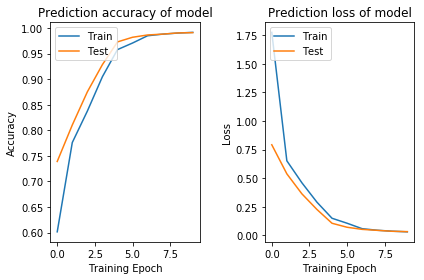

In [18]:
plot_training_history(history)